In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-110u3arb
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-110u3arb
  Resolved https://github.com/albumentations-team/albumentations to commit dfa92b81d855e52f98985f7c7f7307a8ab07116f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


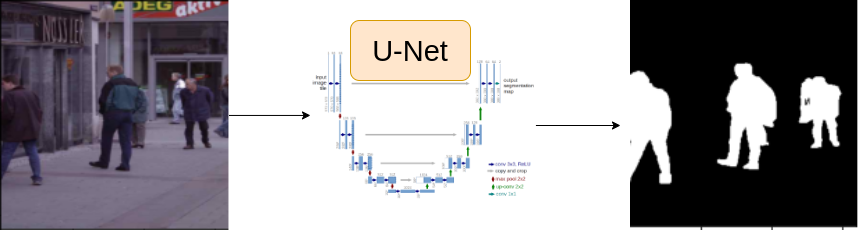

# Some Common Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
import helper

In [ ]:
## making train.csv

import os
import pandas as pd

# Define the directories
image_dir = '/content/drive/MyDrive/Sclera_dataset/images'
mask_dir = '/content/drive/MyDrive/Sclera_dataset/masks'

# List all files in the directories
image_files = sorted([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
mask_files = sorted([f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))])

# Check that the number of images and masks match
assert len(image_files) == len(mask_files), "The number of images and masks should be the same."

# Create full paths
images = [os.path.join(image_dir, f) for f in image_files]
masks = [os.path.join(mask_dir, f) for f in mask_files]

# Create a DataFrame
df = pd.DataFrame({'images': images, 'masks': masks})
df=df.drop(index=0)
# Save to CSV
df.to_csv('/content/drive/MyDrive/Sclera_dataset/train.csv', index=False)


In [ ]:
import os
import pandas as pd

# Setup Configurations

In [ ]:
CSV_FILE='/content/drive/MyDrive/Sclera_dataset/train.csv'
DATA_DIR='/content/drive/MyDrive'

DEVICE='cpu' ## use cuda if you have gpu

EPOCHS=25
LR=0.003
IMAGE_SIZE=128
BATCH_SIZE=16

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)

In [ ]:
df.head()

,images,masks
0,/content/drive/MyDrive/Sclera_dataset/images/1...,/content/drive/MyDrive/Sclera_dataset/masks/1.png
1,/content/drive/MyDrive/Sclera_dataset/images/1...,/content/drive/MyDrive/Sclera_dataset/masks/10...
2,/content/drive/MyDrive/Sclera_dataset/images/1...,/content/drive/MyDrive/Sclera_dataset/masks/11...
3,/content/drive/MyDrive/Sclera_dataset/images/1...,/content/drive/MyDrive/Sclera_dataset/masks/12...
4,/content/drive/MyDrive/Sclera_dataset/images/1...,/content/drive/MyDrive/Sclera_dataset/masks/13...


In [ ]:
row=df.iloc[16]
image_path=row['images']
mask_path=row['masks']

In [ ]:
mask_path

'/content/drive/MyDrive/Sclera_dataset/masks/24.png'

In [ ]:
image_path

'/content/drive/MyDrive/Sclera_dataset/images/24.jpg'

In [ ]:
row=df.iloc[16]
image_path=row['images']
mask_path=row['masks']
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

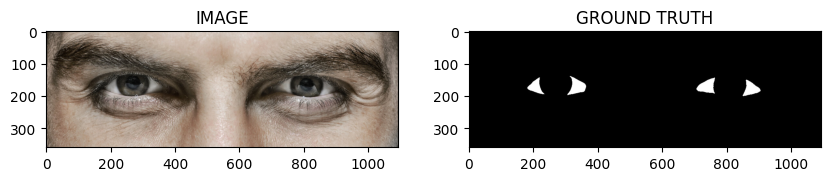

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df = train_test_split(df,test_size=0.2,random_state=42)

#Augmentation Functions

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row=self.df.iloc[idx]
    image_path=row['images']
    mask_path=row['masks']

    image=cv2.imread(image_path)
    image=cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=cv2.resize(mask,(IMAGE_SIZE,IMAGE_SIZE))
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    image=np.transpose(image,(2,0,1))
    mask=np.transpose(mask,(2,0,1))

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [ ]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 48
Size of Validset : 12


In [ ]:
trainset[2]

(tensor([[[0.8745, 0.8588, 0.9216,  ..., 0.7686, 0.4941, 0.6196],
          [0.8471, 0.8627, 0.8588,  ..., 0.8275, 0.6941, 0.5608],
          [0.8471, 0.8510, 0.8588,  ..., 0.7412, 0.6706, 0.7451],
          ...,
          [0.8980, 0.8863, 0.8902,  ..., 0.8784, 0.8549, 0.8588],
          [0.8863, 0.8824, 0.8863,  ..., 0.8353, 0.8627, 0.8667],
          [0.8863, 0.8784, 0.8902,  ..., 0.8549, 0.8784, 0.8510]],
 
         [[0.7608, 0.7804, 0.8431,  ..., 0.7020, 0.4314, 0.5569],
          [0.7373, 0.7608, 0.7451,  ..., 0.7922, 0.6392, 0.4902],
          [0.7176, 0.7294, 0.7373,  ..., 0.6549, 0.5569, 0.7176],
          ...,
          [0.8549, 0.8471, 0.8667,  ..., 0.8627, 0.7451, 0.8314],
          [0.8431, 0.8353, 0.8627,  ..., 0.7804, 0.7686, 0.8000],
          [0.8431, 0.8314, 0.8667,  ..., 0.8078, 0.7843, 0.7843]],
 
         [[0.6000, 0.6471, 0.7412,  ..., 0.6667, 0.3882, 0.4941],
          [0.5490, 0.5686, 0.5725,  ..., 0.7412, 0.6039, 0.4824],
          [0.5490, 0.5490, 0.5765,  ...,

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')


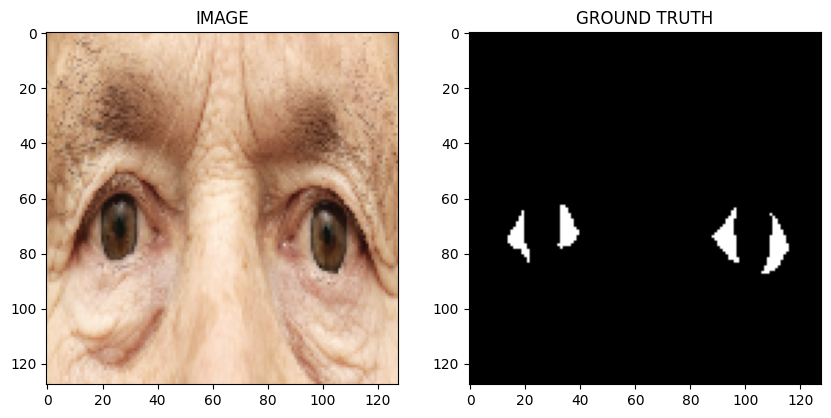

In [ ]:
idx=29

image, mask=trainset[idx]
show_image(image,mask)

#Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
print(f"total number of batches in trainloader:{len(trainloader)}")
print(f"total number of batches in validloader:{len(validloader)}")

total number of batches in trainloader:3
total number of batches in validloader:1


In [ ]:
for image,mask in trainloader:
  break
print(f"one batch size image shape : {image.shape}")
print(f"one batch size mask shape : {mask.shape}")

one batch size image shape : torch.Size([16, 3, 128, 128])
one batch size mask shape : torch.Size([16, 1, 128, 128])


Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!= None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)

      return logits,loss1+loss2

    return logits

In [ ]:
model=SegmentationModel()
# model.to(DEVICE)

In [ ]:
model

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):
    # images=images.to(DEVICE)
    # masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)


In [ ]:
def eval_fn(data_loader,model):

  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      # images=images.to(DEVICE)
      # masks=masks.to(DEVICE)
      logits,loss=model(images,masks)
      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Saved Model")
    best_valid_loss=valid_loss

  print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")


100%|██████████| 1/1 [00:09<00:00,  9.51s/it]


Saved Model
Epoch: 1 Train_loss: 1.6510401566823323 Valid_loss: 1.6383260488510132


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch: 2 Train_loss: 1.3518640597661336 Valid_loss: 1.8079973459243774


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Saved Model
Epoch: 3 Train_loss: 1.1801247596740723 Valid_loss: 1.4212781190872192


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Saved Model
Epoch: 4 Train_loss: 1.0537357330322266 Valid_loss: 1.3132048845291138


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Saved Model
Epoch: 5 Train_loss: 0.9506101210912069 Valid_loss: 1.3002947568893433


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Saved Model
Epoch: 6 Train_loss: 0.8448440233866373 Valid_loss: 0.9505355954170227


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Saved Model
Epoch: 7 Train_loss: 0.7048375805219015 Valid_loss: 0.7627114653587341


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Saved Model
Epoch: 8 Train_loss: 0.5858414570490519 Valid_loss: 0.5683562755584717


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Saved Model
Epoch: 9 Train_loss: 0.5237496892611185 Valid_loss: 0.5177674889564514


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Saved Model
Epoch: 10 Train_loss: 0.4250592390696208 Valid_loss: 0.49188128113746643


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Epoch: 11 Train_loss: 0.3859030206998189 Valid_loss: 0.5711368918418884


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Saved Model
Epoch: 12 Train_loss: 0.3852357566356659 Valid_loss: 0.36727622151374817


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch: 13 Train_loss: 0.3224865347146988 Valid_loss: 0.4521671235561371


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Saved Model
Epoch: 14 Train_loss: 0.27454274396101636 Valid_loss: 0.3215615749359131


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Saved Model
Epoch: 15 Train_loss: 0.2352614551782608 Valid_loss: 0.28769630193710327


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Saved Model
Epoch: 16 Train_loss: 0.2310500591993332 Valid_loss: 0.2812558114528656


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Saved Model
Epoch: 17 Train_loss: 0.2154030700524648 Valid_loss: 0.254276841878891


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch: 18 Train_loss: 0.23201924562454224 Valid_loss: 0.3759576082229614


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Saved Model
Epoch: 19 Train_loss: 0.20126895109812418 Valid_loss: 0.24801947176456451


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Epoch: 20 Train_loss: 0.18902218341827393 Valid_loss: 0.2735852599143982


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Epoch: 21 Train_loss: 0.18277259667714438 Valid_loss: 0.2720873951911926


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Saved Model
Epoch: 22 Train_loss: 0.17500494917233786 Valid_loss: 0.24477075040340424


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Saved Model
Epoch: 23 Train_loss: 0.20810257395108542 Valid_loss: 0.2354334592819214


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Saved Model
Epoch: 24 Train_loss: 0.1608916918436686 Valid_loss: 0.22083914279937744


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Epoch: 25 Train_loss: 0.17059472699960074 Valid_loss: 0.24754607677459717


# Inference

In [ ]:
idx=5
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask = validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

In [ ]:
image.shape

torch.Size([3, 128, 128])

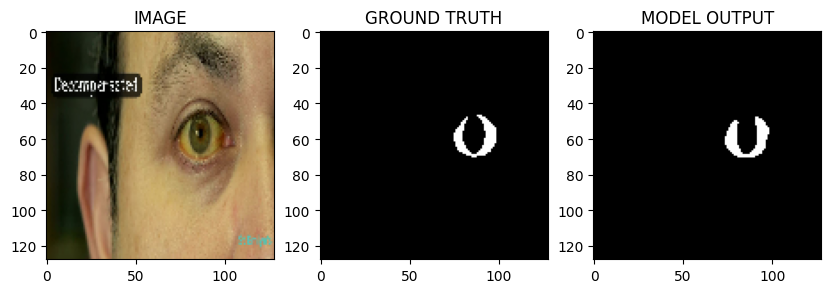

In [ ]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

In [ ]:
# test on real images

In [ ]:
test_path='/content/drive/MyDrive/Sclera_dataset/test/test3.png'

In [ ]:
image=cv2.imread(test_path)
image=cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=np.transpose(image,(2,0,1))
image=torch.Tensor(image)/255.0

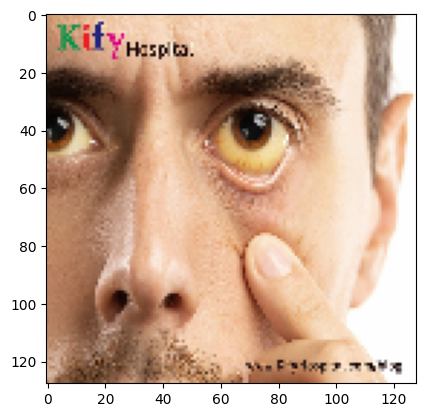

In [ ]:
plt.imshow(image.permute(1,2,0),cmap = 'gray')

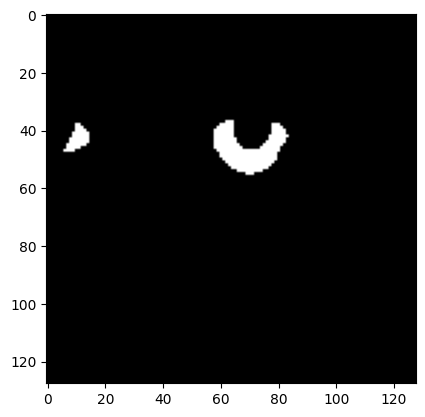

In [ ]:
logits_mask=model(image.unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0
pred_mask=pred_mask.squeeze(0)
plt.imshow(pred_mask.permute(1,2,0),cmap = 'gray')